In [339]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.read_csv("wdbc.data", sep=",", header=None).iloc[:,1:32]

data.replace(to_replace="M", value=1, inplace=True)
data.replace(to_replace="B", value=0, inplace=True)

In [340]:
column_names = []
for i in range(31):
    if i == 0: 
        column_names.append("class")
    else:
        column_names.append(str(i))
data.columns = column_names
pos_msk = np.random.rand(len(positive_data)) < 0.8
neg_msk = np.random.rand(len(negative_data)) < 0.8
positive_data = data[data["class"] == 1]
negative_data = data[data["class"] == 0]


The best penalty parameter is {'C': 10.0} with a score of 0.97
training set confusion matrix:
 [[281   0]
 [  5 153]]
testing set confusion matrix:
 [[50 26]
 [ 0 54]]


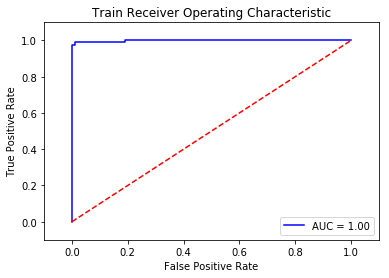

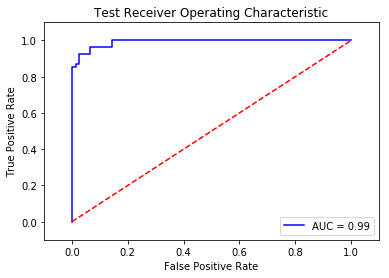

The best penalty parameter is {'C': 1.0} with a score of 0.97
The best penalty parameter is {'C': 1.0} with a score of 0.98
The best penalty parameter is {'C': 1.0} with a score of 0.97
The best penalty parameter is {'C': 1.0} with a score of 0.97
The best penalty parameter is {'C': 10.0} with a score of 0.97
The best penalty parameter is {'C': 1000000.0} with a score of 0.97
The best penalty parameter is {'C': 10.0} with a score of 0.97
The best penalty parameter is {'C': 10.0} with a score of 0.97
The best penalty parameter is {'C': 10.0} with a score of 0.97
The best penalty parameter is {'C': 10.0} with a score of 0.97
The best penalty parameter is {'C': 100.0} with a score of 0.97
The best penalty parameter is {'C': 10000.0} with a score of 0.97
The best penalty parameter is {'C': 1.0} with a score of 0.97
The best penalty parameter is {'C': 10.0} with a score of 0.97
The best penalty parameter is {'C': 1.0} with a score of 0.97
The best penalty parameter is {'C': 10.0} with a sco

In [341]:
'''
b (i)
'''
import warnings
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import metrics


min_max_scaler = preprocessing.MinMaxScaler()
warnings.filterwarnings("ignore", category=Warning)
PENALTY_PRAMA_POINTS = 10
C_range = np.logspace(-3, 6, PENALTY_PRAMA_POINTS)
param_grid = dict(C=C_range)
kf = KFold(n_splits=5)
linearSVC = LinearSVC(penalty='l1', dual=False, tol=1e-3, max_iter = 100)

#accuracy 
train_accuracies = []
test_accuracies = []
#F-score
train_f_scores = []
test_f_scores = []
#Precision
train_precisions = []
test_precisions = []
#Recall
train_recalls = []
test_recalls = []
#AUC
train_AUCs = []
test_AUCs = []

print_report = True 
for i in range(30):
    #shuffle
    train_data = pd.concat([positive_data[pos_msk], negative_data[neg_msk]]).sample(frac=1)
    test_data = pd.concat([positive_data[~pos_msk], negative_data[~neg_msk]]).sample(frac=1)
    
    np_train_data_features = train_data.iloc[:,1:31].values
    np_test_data_features = test_data.iloc[:,1:31].values
    np_train_data_targets = train_data['class'].values.ravel()
    np_test_data_targets = test_data['class'].values.ravel()
    
    #normalize
    np_train_features_scaled = min_max_scaler.fit_transform(np_train_data_features)
    np_test_features_scaled = min_max_scaler.fit_transform(np_test_data_features)
    #CV 
    gridCV = GridSearchCV(estimator=linearSVC, param_grid=param_grid, scoring='accuracy',cv=kf)
    gridCV.fit(np_train_features_scaled, np_train_data_targets)
    
    print("The best penalty parameter is %s with a score of %0.2f"
      % (gridCV.best_params_, gridCV.best_score_))
    
    temp_best_C = gridCV.best_params_['C']
    temp_linearSVC = LinearSVC(penalty='l1', dual=False, tol=1e-3, max_iter = 100, C = temp_best_C)
    temp_linearSVC.fit(np_train_features_scaled, np_train_data_targets)
    temp_train_score = temp_linearSVC.score(np_train_features_scaled, np_train_data_targets)
    temp_test_score = temp_linearSVC.score(np_test_features_scaled, np_test_data_targets)
    
    
    train_pred = temp_linearSVC.predict(np_train_features_scaled)
    test_pred = temp_linearSVC.predict(np_test_features_scaled)
    
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(np_train_data_targets, train_pred).ravel()
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(np_test_data_targets, test_pred).ravel()
    
    
    # use score instead of pred for roc 
    train_confident_score = temp_linearSVC.decision_function(np_train_features_scaled)
    test_confident_score = temp_linearSVC.decision_function(np_test_features_scaled)
    
    fpr_train, tpr_train, threshold_train = metrics.roc_curve(np_train_data_targets, train_confident_score)
    fpr_test, tpr_test, threshold_test = metrics.roc_curve(np_test_data_targets, test_confident_score)
    
    
    #accuracy 
    train_accuracies.append(gridCV.best_score_)
    test_accuracies.append(temp_test_score)
    #F-score
    train_f_scores.append(f1_score(np_train_data_targets, train_pred, average="binary"))
    test_f_scores.append(f1_score(np_test_data_targets, test_pred, average="binary"))
    #Precision
    train_precisions.append(tp_train / (tp_train + fp_train))
    test_precisions.append(tp_test / (tp_test + fp_test))
    #Recall 
    train_recalls.append(tp_train / (tp_train + fn_train))
    test_recalls.append(tp_test / (tp_test + fn_test))
    #AUC
    train_AUCs.append(metrics.auc(fpr_train, tpr_train))
    test_AUCs.append(metrics.auc(fpr_test, tpr_test))
    
    if print_report:
        print ("training set confusion matrix:\n",confusion_matrix(np_train_data_targets, train_pred))
        print ("testing set confusion matrix:\n",confusion_matrix(np_test_data_targets, test_pred))
        print_report = False
        
        train_roc_auc = metrics.auc(fpr_train, tpr_train)
        plt.title('Train Receiver Operating Characteristic')
        plt.plot(fpr_train, tpr_train, 'b', label = 'AUC = %0.2f' % train_roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-0.1, 1.1])
        plt.ylim([-0.1, 1.1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
        
        test_roc_auc = metrics.auc(fpr_test, tpr_test)
        plt.title('Test Receiver Operating Characteristic')
        plt.plot(fpr_test, tpr_test, 'b', label = 'AUC = %0.2f' % test_roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-0.1, 1.1])
        plt.ylim([-0.1, 1.1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()


In [342]:
print ("Average Train accuracy:", np.mean(train_accuracies), "Average Test accuracy:", np.mean(test_accuracies))
print ("Average Train F-score:", np.mean(train_f_scores), "Average Test F-score:", np.mean(test_f_scores))
print ("Average Train precision:", np.mean(train_precisions), "Average Test precision:", np.mean(test_precisions))
print ("Average Train recall:", np.mean(train_recalls), "Average Test recall:", np.mean(test_recalls))
print ("Average Train AUC:", np.mean(train_AUCs), "Average Test AUC:", np.mean(test_AUCs))

Average Train accuracy: 0.9719817767653761 Average Test accuracy: 0.8405128205128204
Average Train F-score: 0.9818392010802961 Average Test F-score: 0.8416096347575963
Average Train precision: 1.0 Average Test precision: 0.7320674495674218
Average Train recall: 0.9643459915611815 Average Test recall: 0.9969135802469135
Average Train AUC: 0.9983310059011667 Average Test AUC: 0.9902534113060428


In [343]:
train_pos_data = positive_data[pos_msk]
test_pos_data = positive_data[~pos_msk]
train_neg_data = negative_data[neg_msk]
test_neg_data = negative_data[~neg_msk]

train_half_msk_pos = np.random.rand(len(train_pos_data)) < 0.5
train_half_msk_neg = np.random.rand(len(train_neg_data)) < 0.5

labeled_train = pd.concat([train_pos_data[train_half_msk_pos], train_neg_data[train_half_msk_neg]]).sample(frac=1)
unlabeled_train = pd.concat([train_pos_data[~train_half_msk_pos], train_neg_data[~train_half_msk_neg]]).sample(frac=1)



The best penalty parameter is {'C': 1.0} with a score of 0.96
training set confusion matrix:
 [[180  10]
 [  8 241]]
testing set confusion matrix:
 [[61 15]
 [ 3 51]]


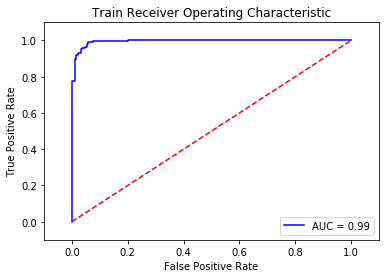

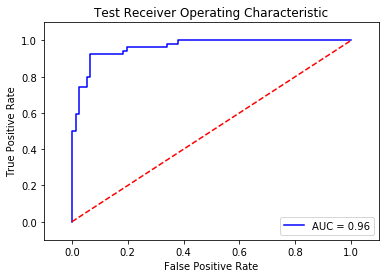

The best penalty parameter is {'C': 1.0} with a score of 0.96
The best penalty parameter is {'C': 10000.0} with a score of 0.96
The best penalty parameter is {'C': 1.0} with a score of 0.97
The best penalty parameter is {'C': 1.0} with a score of 0.98
The best penalty parameter is {'C': 1.0} with a score of 0.96
The best penalty parameter is {'C': 100.0} with a score of 0.96
The best penalty parameter is {'C': 1.0} with a score of 0.96
The best penalty parameter is {'C': 0.1} with a score of 0.96
The best penalty parameter is {'C': 10.0} with a score of 0.97
The best penalty parameter is {'C': 1.0} with a score of 0.97
The best penalty parameter is {'C': 1.0} with a score of 0.96
The best penalty parameter is {'C': 1.0} with a score of 0.96
The best penalty parameter is {'C': 1.0} with a score of 0.97
The best penalty parameter is {'C': 1.0} with a score of 0.96
The best penalty parameter is {'C': 100.0} with a score of 0.96
The best penalty parameter is {'C': 100.0} with a score of 0.

In [344]:
'''
b (ii)
'''
#https://stackoverflow.com/questions/32074239/sklearn-getting-distance-of-each-point-from-decision-boundary
#label unlabled data and put in labeled data 
def labelData(svc, np_unlabeled_data_features,np_train_data_features, np_train_data_targets):
    np_length = np.size(np_unlabeled_data_features,0)
    while np_length != 0:
        furthest_dist = 0
        furthest_index = 0 
        #print("unlabeled data len:",np_length )
        for i in range(np_length):
            x = [np_unlabeled_data_features[i]]
            y = svc.decision_function(x)
            w_norm = np.linalg.norm(svc.coef_)
            dist = y / w_norm
            if dist > furthest_dist:
                furthest_dist = dist
                furthest_index = i 
        new_label = svc.predict([np_unlabeled_data_features[furthest_index]])
        new_feature = [np_unlabeled_data_features[furthest_index]]
        #add new data point to labeled set
        np_train_data_features = np.concatenate((np_train_data_features, new_feature))
        np_train_data_targets = np.concatenate((np_train_data_targets, new_label))
        np_unlabeled_data_features = np.delete(np_unlabeled_data_features, furthest_index, 0)
        #print(furthest_dist,furthest_index)
        np_length = np.size(np_unlabeled_data_features,0)
        svc.fit(np_train_data_features, np_train_data_targets)
    return svc, np_train_data_features, np_train_data_targets
    
#accuracy 
train_accuracies = []
test_accuracies = []
#F-score
train_f_scores = []
test_f_scores = []
#Precision
train_precisions = []
test_precisions = []
#Recall
train_recalls = []
test_recalls = []
#AUC
train_AUCs = []
test_AUCs = []

print_report = True 
for i in range(30):
    #shuffle
    labeled_train = pd.concat([train_pos_data[train_half_msk_pos], train_neg_data[train_half_msk_neg]]).sample(frac=1)
    unlabeled_train = pd.concat([train_pos_data[~train_half_msk_pos], train_neg_data[~train_half_msk_neg]]).sample(frac=1)
    
    
    test_data = pd.concat([test_pos_data, test_neg_data]).sample(frac=1)
    
    np_train_data_features = labeled_train.iloc[:,1:31].values
    np_test_data_features = test_data.iloc[:,1:31].values
    np_train_data_targets = labeled_train['class'].values.ravel()
    np_test_data_targets = test_data['class'].values.ravel()
    
    np_unlabeled_train_data_features = unlabeled_train.iloc[:,1:31].values
    np_unlabeled_train_data_targets = unlabeled_train['class'].values
    #print(np_unlabeled_train_data_features, np_unlabeled_train_data_targets)
    
    #normalize
    np_train_features_scaled = min_max_scaler.fit_transform(np_train_data_features)
    np_test_features_scaled = min_max_scaler.fit_transform(np_test_data_features)
    np_unlabeled_train_feature_scaled =  min_max_scaler.fit_transform(np_unlabeled_train_data_features)
    #CV 
    gridCV = GridSearchCV(estimator=linearSVC, param_grid=param_grid, scoring='accuracy',cv=kf)
    gridCV.fit(np_train_features_scaled, np_train_data_targets)
    
    print("The best penalty parameter is %s with a score of %0.2f"
      % (gridCV.best_params_, gridCV.best_score_))
    
    temp_best_C = gridCV.best_params_['C']
    temp_linearSVC = LinearSVC(penalty='l1', dual=False, tol=1e-3, max_iter = 100, C = temp_best_C)
    temp_linearSVC.fit(np_train_features_scaled, np_train_data_targets)
    temp_train_score = temp_linearSVC.score(np_train_features_scaled, np_train_data_targets)
    temp_test_score = temp_linearSVC.score(np_test_features_scaled, np_test_data_targets)
    
    #print(np_train_data_features,np_train_data_targets)
    temp_linearSVC, np_train_features_scaled, np_train_data_targets = labelData(temp_linearSVC, 
                                                                             np_unlabeled_train_feature_scaled, 
                                                                             np_train_features_scaled, 
                                                                             np_train_data_targets)
    #print(np_train_data_features,np_train_data_targets)
    
    train_pred = temp_linearSVC.predict(np_train_features_scaled)
    test_pred = temp_linearSVC.predict(np_test_features_scaled)
    
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(np_train_data_targets, train_pred).ravel()
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(np_test_data_targets, test_pred).ravel()
    
    # use score instead of pred for roc 
    train_confident_score = temp_linearSVC.decision_function(np_train_features_scaled)
    test_confident_score = temp_linearSVC.decision_function(np_test_features_scaled)
    
    fpr_train, tpr_train, threshold_train = metrics.roc_curve(np_train_data_targets, train_confident_score)
    fpr_test, tpr_test, threshold_test = metrics.roc_curve(np_test_data_targets, test_confident_score)
    
    #accuracy 
    train_accuracies.append(gridCV.best_score_)
    test_accuracies.append(temp_test_score)
    #F-score
    train_f_scores.append(f1_score(np_train_data_targets, train_pred, average="binary"))
    test_f_scores.append(f1_score(np_test_data_targets, test_pred, average="binary"))
    #Precision
    train_precisions.append(tp_train / (tp_train + fp_train))
    test_precisions.append(tp_test / (tp_test + fp_test))
    #Recall 
    train_recalls.append(tp_train / (tp_train + fn_train))
    test_recalls.append(tp_test / (tp_test + fn_test))
    #AUC
    train_AUCs.append(metrics.auc(fpr_train, tpr_train))
    test_AUCs.append(metrics.auc(fpr_test, tpr_test))
    
    if print_report:
        print ("training set confusion matrix:\n",confusion_matrix(np_train_data_targets, train_pred))
        print ("testing set confusion matrix:\n",confusion_matrix(np_test_data_targets, test_pred))
        print_report = False
        
        train_roc_auc = metrics.auc(fpr_train, tpr_train)
        plt.title('Train Receiver Operating Characteristic')
        plt.plot(fpr_train, tpr_train, 'b', label = 'AUC = %0.2f' % train_roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-0.1, 1.1])
        plt.ylim([-0.1, 1.1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
        
        test_roc_auc = metrics.auc(fpr_test, tpr_test)
        plt.title('Test Receiver Operating Characteristic')
        plt.plot(fpr_test, tpr_test, 'b', label = 'AUC = %0.2f' % test_roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-0.1, 1.1])
        plt.ylim([-0.1, 1.1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()



In [345]:
print ("Average Train accuracy:", np.mean(train_accuracies), "Average Test accuracy:", np.mean(test_accuracies))
print ("Average Train F-score:", np.mean(train_f_scores), "Average Test F-score:", np.mean(test_f_scores))
print ("Average Train precision:", np.mean(train_precisions), "Average Test precision:", np.mean(test_precisions))
print ("Average Train recall:", np.mean(train_recalls), "Average Test recall:", np.mean(test_recalls))
print ("Average Train AUC:", np.mean(train_AUCs), "Average Test AUC:", np.mean(test_AUCs))

Average Train accuracy: 0.9640117994100296 Average Test accuracy: 0.8451282051282052
Average Train F-score: 0.9736401799907858 Average Test F-score: 0.8185174574756288
Average Train precision: 0.9696121061953954 Average Test precision: 0.7145073515750905
Average Train recall: 0.9779572638470185 Average Test recall: 0.967901234567901
Average Train AUC: 0.995803247541175 Average Test AUC: 0.9612085769980505


training set confusion matrix:
 [[280   1]
 [ 59  99]]
testing set confusion matrix:
 [[76  0]
 [23 31]]


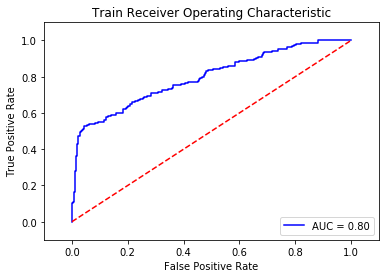

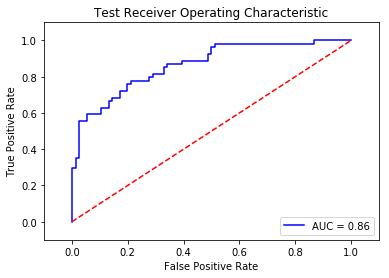

In [353]:
'''
b (iii)
'''
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin_min, accuracy_score

def get_kmean_probabilities(distances):
    probs = []
    for i in range (len(distances[0])):
        prob = 0
        if distances[0][i] > distances[1][i]:
            prob = distances[1][i] / (distances[0][i] + distances[1][i]) 
            
        else:
            prob = distances[0][i] / (distances[0][i] + distances[1][i]) 
            
        probs.append(prob)
    return probs     
#accuracy 
train_accuracies = []
test_accuracies = []
#F-score
train_f_scores = []
test_f_scores = []
#Precision
train_precisions = []
test_precisions = []
#Recall
train_recalls = []
test_recalls = []
#AUC
train_AUCs = []
test_AUCs = []

print_report = True 
for i in range(30):
    #shuffle
    train_data = pd.concat([positive_data[pos_msk], negative_data[neg_msk]]).sample(frac=1)
    test_data = pd.concat([positive_data[~pos_msk], negative_data[~neg_msk]]).sample(frac=1)
    
    np_train_data_features = train_data.iloc[:,1:31].values
    np_test_data_features = test_data.iloc[:,1:31].values
    np_train_data_targets = train_data['class'].values.ravel()
    np_test_data_targets = test_data['class'].values.ravel()
    
    
    kmeans = KMeans(n_clusters=2, random_state=i).fit(np_train_data_features)
    test_labels = kmeans.predict(np_test_data_features)
    
    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, np_train_data_features)
    #print(closest)
    
    train_distances = pairwise_distances(kmeans.cluster_centers_, np_train_data_features)
    test_distances = pairwise_distances(kmeans.cluster_centers_, np_test_data_features)
    
    distances_and_index_K0 = []
    distances_and_index_K1 = []
    for i in range (len(train_distances[0])):
        distances_and_index_K0.append([train_distances[0][i], i])
        distances_and_index_K1.append([train_distances[1][i], i])
    distances_and_index_K0 = sorted(distances_and_index_K0, key=lambda tup: tup[0])
    distances_and_index_K1 = sorted(distances_and_index_K1, key=lambda tup: tup[0])
    
    
    #get true label for cluster 
    label_K0 = 0
    label_K1 = 0
    
    for i in range (30):
        index_K0 = distances_and_index_K0[i][1]
        label_K0 += np_train_data_targets[index_K0]
        index_K1 = distances_and_index_K1[i][1]
        label_K1 += np_train_data_targets[index_K1]
    
    label_K0 = 0 if label_K0 < 15 else 1 
    label_K1 = 0 if label_K1 < 15 else 1 
    
    # label assigned by kmeans 
    cluster_label_0 = kmeans.labels_[closest[0]]
    cluster_label_1 = kmeans.labels_[closest[1]]
    
    # set correct label based on cluster 
    train_pred = kmeans.labels_
    test_pred = test_labels
    
    if(label_K0 != cluster_label_0): 
        for i in range(len(train_pred)):
            train_pred[i] = 0 if train_pred[i] == 1 else 1
        for i in range(len(test_pred)):
            test_pred[i] = 0 if test_pred[i] == 1 else 1
    
    
    temp_train_score = accuracy_score(np_train_data_targets, train_pred)
    temp_test_score = accuracy_score(np_test_data_targets, test_pred)
    
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(np_train_data_targets, train_pred).ravel()
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(np_test_data_targets, test_pred).ravel()
    
     # use score instead of pred for roc 
    train_confident_score = get_kmean_probabilities(train_distances)
    test_confident_score = get_kmean_probabilities(test_distances)
    
    fpr_train, tpr_train, threshold_train = metrics.roc_curve(np_train_data_targets, train_confident_score)
    fpr_test, tpr_test, threshold_test = metrics.roc_curve(np_test_data_targets, test_confident_score)
    
    
    #accuracy 
    train_accuracies.append(temp_train_score)
    test_accuracies.append(temp_test_score)
    #F-score
    train_f_scores.append(f1_score(np_train_data_targets, train_pred, average="binary"))
    test_f_scores.append(f1_score(np_test_data_targets, test_pred, average="binary"))
    #Precision
    train_precisions.append(tp_train / (tp_train + fp_train))
    test_precisions.append(tp_test / (tp_test + fp_test))
    #Recall 
    train_recalls.append(tp_train / (tp_train + fn_train))
    test_recalls.append(tp_test / (tp_test + fn_test))
    #AUC
    train_AUCs.append(metrics.auc(fpr_train, tpr_train))
    test_AUCs.append(metrics.auc(fpr_test, tpr_test))
    
    if print_report:
        print ("training set confusion matrix:\n",confusion_matrix(np_train_data_targets, train_pred))
        print ("testing set confusion matrix:\n",confusion_matrix(np_test_data_targets, test_pred))
        print_report = False
        
        train_roc_auc = metrics.auc(fpr_train, tpr_train)
        plt.title('Train Receiver Operating Characteristic')
        plt.plot(fpr_train, tpr_train, 'b', label = 'AUC = %0.2f' % train_roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-0.1, 1.1])
        plt.ylim([-0.1, 1.1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
        
        test_roc_auc = metrics.auc(fpr_test, tpr_test)
        plt.title('Test Receiver Operating Characteristic')
        plt.plot(fpr_test, tpr_test, 'b', label = 'AUC = %0.2f' % test_roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-0.1, 1.1])
        plt.ylim([-0.1, 1.1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

In [354]:
print ("Average Train accuracy:", np.mean(train_accuracies), "Average Test accuracy:", np.mean(test_accuracies))
print ("Average Train F-score:", np.mean(train_f_scores), "Average Test F-score:", np.mean(test_f_scores))
print ("Average Train precision:", np.mean(train_precisions), "Average Test precision:", np.mean(test_precisions))
print ("Average Train recall:", np.mean(train_recalls), "Average Test recall:", np.mean(test_recalls))
print ("Average Train AUC:", np.mean(train_AUCs), "Average Test AUC:", np.mean(test_AUCs))

Average Train accuracy: 0.8633257403189065 Average Test accuracy: 0.8230769230769229
Average Train F-score: 0.7674418604651162 Average Test F-score: 0.7294117647058826
Average Train precision: 0.9899999999999997 Average Test precision: 1.0
Average Train recall: 0.6265822784810128 Average Test recall: 0.5740740740740741
Average Train AUC: 0.7956664714626785 Average Test AUC: 0.864522417153996


training set confusion matrix:
 [[279   2]
 [ 57 101]]
testing set confusion matrix:
 [[76  0]
 [40 14]]


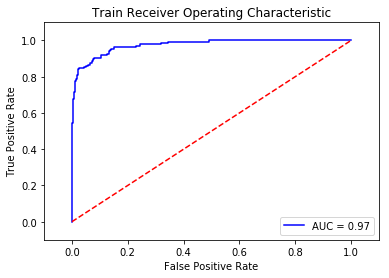

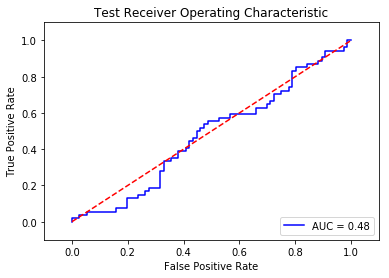

In [375]:
'''
b (iv)
'''
from sklearn.cluster import SpectralClustering

#accuracy 
train_accuracies = []
test_accuracies = []
#F-score
train_f_scores = []
test_f_scores = []
#Precision
train_precisions = []
test_precisions = []
#Recall
train_recalls = []
test_recalls = []
#AUC
train_AUCs = []
test_AUCs = []

print_report = True 
for i in range(30):
    #shuffle
    train_data = pd.concat([positive_data[pos_msk], negative_data[neg_msk]]).sample(frac=1)
    test_data = pd.concat([positive_data[~pos_msk], negative_data[~neg_msk]]).sample(frac=1)
    
    np_train_data_features = train_data.iloc[:,1:31].values
    np_test_data_features = test_data.iloc[:,1:31].values
    np_train_data_targets = train_data['class'].values.ravel()
    np_test_data_targets = test_data['class'].values.ravel()
    
    #normalize
    np_train_features_scaled = min_max_scaler.fit_transform(np_train_data_features)
    np_test_features_scaled = min_max_scaler.fit_transform(np_test_data_features)
    
    # rbf is unstable due to "The factorization of 'b' could not be completed and no eigenvalues or eigenvectors were computed." ERROR
    clustering = SpectralClustering(affinity='rbf', n_clusters=2, random_state=0).fit(np_train_features_scaled)
    train_pred = clustering.labels_
    test_pred = clustering.fit_predict(np_test_features_scaled)
    
    temp_train_score = accuracy_score(np_train_data_targets, train_pred)
    temp_test_score = accuracy_score(np_test_data_targets, test_pred)
    
    if(temp_train_score < 0.5): 
        for i in range(len(train_pred)):
            train_pred[i] = 0 if train_pred[i] == 1 else 1
    if(temp_test_score < 0.5):   
        for i in range(len(test_pred)):
            test_pred[i] = 0 if test_pred[i] == 1 else 1
    temp_train_score = accuracy_score(np_train_data_targets, train_pred)
    temp_test_score = accuracy_score(np_test_data_targets, test_pred)
    
    #probability calculation of Spectral Clustering # Cite: Lin
    D_tr = metrics.pairwise_distances(np_train_features_scaled, n_jobs=-1, metric="euclidean")
    for i in range(D_tr.shape[0]):
        D_tr[i, i] = np.inf
    indices0 = np.argwhere(train_pred == 0).ravel()
    indices1 = np.argwhere(train_pred == 1).ravel()    
    D_tr_min0 = np.amin(D_tr[:, indices0], axis=1).reshape(-1, 1)
    D_tr_min1 = np.amin(D_tr[:, indices1], axis=1).reshape(-1, 1)
    D_tr_min = np.concatenate((D_tr_min0, D_tr_min1), axis=1)
    y_tr_score = np.array(
        [
            1 - D_tr_min[:, 0] / np.sum(D_tr_min, axis=1),
            1 - D_tr_min[:, 1] / np.sum(D_tr_min, axis=1),
        ]
    ).transpose()
    
    
    D_te = metrics.pairwise_distances(np_test_features_scaled, np_train_features_scaled, n_jobs=-1, metric="euclidean")
    indices0 = np.argwhere(test_pred == 0).ravel()
    indices1 = np.argwhere(test_pred == 1).ravel()
    D_te_min0 = np.amin(D_te[:, indices0], axis=1).reshape(-1, 1)
    D_te_min1 = np.amin(D_te[:, indices1], axis=1).reshape(-1, 1)
    D_te_min = np.concatenate((D_te_min0, D_te_min1), axis=1)
    y_te_score = np.array(
        [
            1 - D_te_min[:, 0] / np.sum(D_te_min, axis=1),
            1 - D_te_min[:, 1] / np.sum(D_te_min, axis=1),
        ]
    ).transpose()
    
    #y_tr_score[:, [0, 1]] = y_tr_score[:, [1, 0]]
    #print(y_tr_score)
    #print(y_tr_score[:,0])
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(np_train_data_targets, train_pred).ravel()
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(np_test_data_targets, test_pred).ravel()
    
    fpr_train, tpr_train, threshold_train = metrics.roc_curve(np_train_data_targets, y_tr_score[:,1])
    fpr_test, tpr_test, threshold_test = metrics.roc_curve(np_test_data_targets, y_te_score[:,1])
    
    
    #accuracy 
    train_accuracies.append(temp_train_score)
    test_accuracies.append(temp_test_score)
    #F-score
    train_f_scores.append(f1_score(np_train_data_targets, train_pred, average="binary"))
    test_f_scores.append(f1_score(np_test_data_targets, test_pred, average="binary"))
    #Precision
    train_precisions.append(tp_train / (tp_train + fp_train))
    test_precisions.append(tp_test / (tp_test + fp_test))
    #Recall 
    train_recalls.append(tp_train / (tp_train + fn_train))
    test_recalls.append(tp_test / (tp_test + fn_test))
    #AUC
    train_AUCs.append(metrics.auc(fpr_train, tpr_train))
    test_AUCs.append(metrics.auc(fpr_test, tpr_test))
    
    if print_report:
        print ("training set confusion matrix:\n",confusion_matrix(np_train_data_targets, train_pred))
        print ("testing set confusion matrix:\n",confusion_matrix(np_test_data_targets, test_pred))
        print_report = False
        
        train_roc_auc = metrics.auc(fpr_train, tpr_train)
        plt.title('Train Receiver Operating Characteristic')
        plt.plot(fpr_train, tpr_train, 'b', label = 'AUC = %0.2f' % train_roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-0.1, 1.1])
        plt.ylim([-0.1, 1.1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
        
        test_roc_auc = metrics.auc(fpr_test, tpr_test)
        plt.title('Test Receiver Operating Characteristic')
        plt.plot(fpr_test, tpr_test, 'b', label = 'AUC = %0.2f' % test_roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-0.1, 1.1])
        plt.ylim([-0.1, 1.1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

In [376]:
print ("Average Train accuracy:", np.mean(train_accuracies), "Average Test accuracy:", np.mean(test_accuracies))
print ("Average Train F-score:", np.mean(train_f_scores), "Average Test F-score:", np.mean(test_f_scores))
print ("Average Train precision:", np.mean(train_precisions), "Average Test precision:", np.mean(test_precisions))
print ("Average Train recall:", np.mean(train_recalls), "Average Test recall:", np.mean(test_recalls))
print ("Average Train AUC:", np.mean(train_AUCs), "Average Test AUC:", np.mean(test_AUCs))

Average Train accuracy: 0.8656036446469247 Average Test accuracy: 0.6923076923076924
Average Train F-score: 0.7739463601532568 Average Test F-score: 0.41176470588235303
Average Train precision: 0.9805825242718449 Average Test precision: 1.0
Average Train recall: 0.6392405063291139 Average Test recall: 0.2592592592592593
Average Train AUC: 0.9743682147844495 Average Test AUC: 0.4851770630279403


In [301]:
'''
b(v)
'''
print("It becomes obvious from experiment results that supervised learning performs \
better on average than semisupervised learning, which is better than unsupervised learning: \
with higher metrics from the former and lower metrics from the later")

It becomes obvious from experiment results that supervised learning performs better on average than semisupervised learning, which is better than unsupervised learning: with higher metrics from the former and lower metrics from the later


In [302]:
'''
2 (a)
'''
from sklearn.model_selection import train_test_split
bank_data = pd.read_csv("data_banknote_authentication.txt", sep=",", header=None)
np_bank_data_X = bank_data.iloc[:,0:4].values
np_bank_data_y = bank_data.iloc[:,4:5].values.ravel()



In [321]:
'''
2 (b) i
'''
def checkTwoClasses(y):
    count = 0
    for i in range (10):
        count += y[i]
    return count > 1 and count < 10

PENALTY_PRAMA_POINTS = 10
C_range = np.logspace(-3, 6, PENALTY_PRAMA_POINTS)
linearSVC = LinearSVC(penalty='l1', dual=False, tol=1e-3, max_iter = 100)
kf1 = KFold (n_splits=10)
#kf2 = StratifiedKFold (n_splits=10)
param_grid = dict(C=C_range)
passive_learning_errors_Monte_Carlo = []
for x in range(50):
    bank_train_X, bank_test_X, bank_train_y, bank_test_y = None, None, None, None
    rand_state = x
    while True: 
        
        bank_train_X, bank_test_X, bank_train_y, bank_test_y = train_test_split(np_bank_data_X, 
                                                                            np_bank_data_y, 
                                                                            test_size=472, 
                                                                             random_state=rand_state)
        if (checkTwoClasses(bank_train_y)): 
            break
        else: 
            #print("resample")
            rand_state += 1
    
    chunks_X = np.split(bank_train_X, 90)
    chunks_y = np.split(bank_train_y, 90)
    train_X = []
    train_y = []
    passive_learning_errors = []
    for i in range(90):

        if i == 0:
            train_X = chunks_X[0]
            train_y = chunks_y[0]
        else:
            train_X = np.append(train_X, chunks_X[i], axis = 0)
            train_y = np.append(train_y, chunks_y[i], axis = 0)

        gridCV = GridSearchCV(estimator=linearSVC, param_grid=param_grid, scoring='accuracy',cv=kf1) #if i ==0 else GridSearchCV(estimator=linearSVC, param_grid=param_grid, scoring='accuracy',cv=kf2)
        #print(x, i, chunks_y[0])
        gridCV.fit(train_X,train_y)
        
        best_C = gridCV.best_params_["C"]

        temp_linearSVC = LinearSVC(penalty='l1', dual=False, tol=1e-3, max_iter = 100, C=best_C)
        temp_linearSVC.fit(train_X, train_y)
        temp_test_score = temp_linearSVC.score(bank_test_X, bank_test_y)
        passive_learning_errors.append(temp_test_score)
    passive_learning_errors_Monte_Carlo.append(passive_learning_errors)
#print(passive_learning_errors_Monte_Carlo)  

In [328]:
print(len(passive_learning_errors_Monte_Carlo))


50


In [ ]:
'''
2 (b) ii
'''
import random
from sklearn.model_selection import StratifiedKFold

active_learning_errors_Monte_Carlo = []
for x in range(50):
    bank_train_X, bank_test_X, bank_train_y, bank_test_y = None, None, None, None
    rand_state = x
    while True: 
        
        bank_train_X, bank_test_X, bank_train_y, bank_test_y = train_test_split(np_bank_data_X, 
                                                                            np_bank_data_y, 
                                                                            test_size=472, 
                                                                             random_state=rand_state)
        if (checkTwoClasses(bank_train_y)): 
            break
        else: 
            #print("resample")
            rand_state += 1
    unused_indexes = set(list(range(900)))

    init_random_indexes = random.sample(range(0, 899), 10)
    train_X = [] 
    train_y = []
#     kf1 = KFold (n_splits=10)
    kf2 = StratifiedKFold (n_splits=10)
    for i in range(10):
        index = init_random_indexes[i]
        train_X.append(bank_train_X[index])
        train_y.append(bank_train_y[index])
        unused_indexes.remove(index)
    active_learning_errors = []
    for i in range(90):
        gridCV = GridSearchCV(estimator=linearSVC, param_grid=param_grid, scoring='accuracy',cv=kf1) if i ==0 else GridSearchCV(estimator=linearSVC, param_grid=param_grid, scoring='accuracy',cv=kf2)
        gridCV.fit(train_X,train_y)
        best_C = gridCV.best_params_["C"]

        temp_linearSVC = LinearSVC(penalty='l1', dual=False, tol=1e-3, max_iter = 100, C=best_C)
        temp_linearSVC.fit(train_X, train_y)
        temp_test_score = temp_linearSVC.score(bank_test_X, bank_test_y)
        #print(i, temp_test_score)
        active_learning_errors.append(temp_test_score)
        ten_closest_indexes = []
        if(len(unused_indexes) >= 10):
            for j in range(10):
                closest_dist = sys.maxsize
                closest_index = 0 
                for unused_index in unused_indexes:
                    x = [bank_train_X[unused_index]]
                    y = temp_linearSVC.decision_function(x)
                    w_norm = np.linalg.norm(temp_linearSVC.coef_)
                    dist = y / w_norm
                    if dist < closest_dist:
                        closest_dist = dist
                        closest_index = unused_index 


                ten_closest_indexes.append(closest_index)
                if closest_index in unused_indexes:
                    unused_indexes.remove(closest_index)
                else: 
                    print ("DEBUG", closest_index, "not in set", unused_indexes)
                #print(closest_dist, closest_index)

            for j in range(10):
                index = ten_closest_indexes[j]
                train_X.append(bank_train_X[index])
                train_y.append(bank_train_y[index])
    active_learning_errors_Monte_Carlo.append(active_learning_errors)

In [330]:
'''
2 (c) 
'''
print(len(active_learning_errors_Monte_Carlo))

50


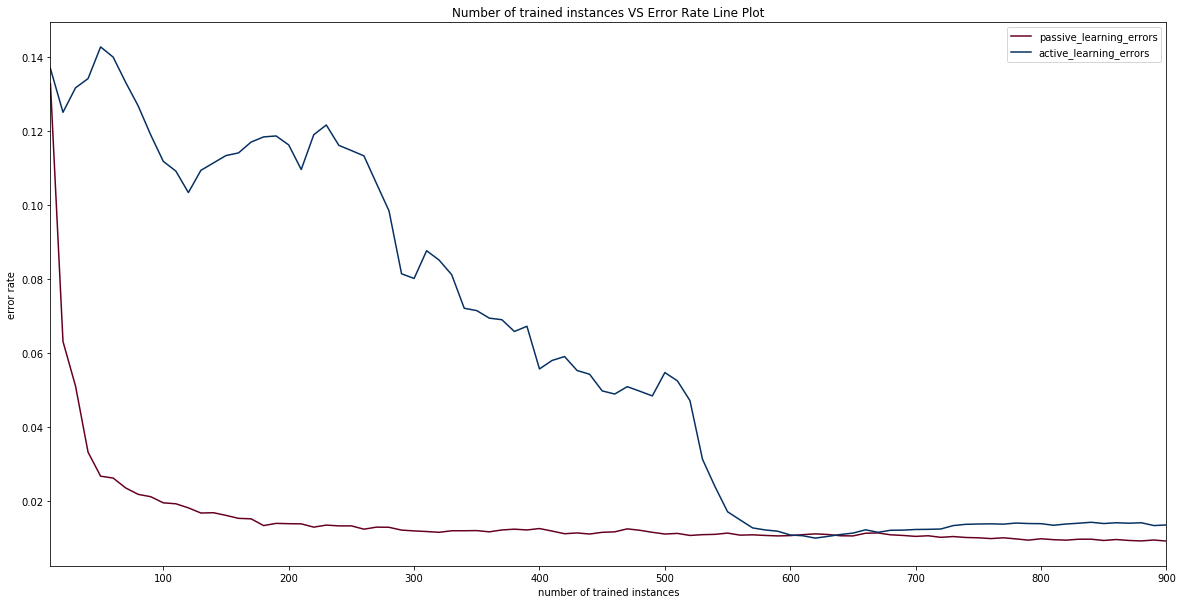

In [336]:
mean_passive_learning_errors_Monte_Carlo = []
mean_active_learning_errors_Monte_Carlo = []
x_indexes = []
for i in range(90):
    x_indexes.append(10*(i+1))
    for j in range (50):
        if j == 0:
            mean_passive_learning_errors_Monte_Carlo.append(1 - passive_learning_errors_Monte_Carlo[j][i])
            mean_active_learning_errors_Monte_Carlo.append(1 - active_learning_errors_Monte_Carlo[j][i])
            
        else :
            mean_passive_learning_errors_Monte_Carlo[i] += 1 - passive_learning_errors_Monte_Carlo[j][i]
            mean_active_learning_errors_Monte_Carlo[i] += 1 - active_learning_errors_Monte_Carlo[j][i]
mean_passive_learning_errors_Monte_Carlo = [x / 50 for x in mean_passive_learning_errors_Monte_Carlo]
mean_active_learning_errors_Monte_Carlo = [x / 50 for x in mean_active_learning_errors_Monte_Carlo]

error_data = []
error_data.append(x_indexes)
error_data.append(mean_passive_learning_errors_Monte_Carlo)
error_data.append(mean_active_learning_errors_Monte_Carlo)
error_data = [*zip(*error_data)] # matrix transpose 
pd_error_data = pd.DataFrame.from_records(error_data, columns=["number of trained instances", "passive_learning_errors", "active_learning_errors"])
pd_error_data.plot(x="number of trained instances", y=["passive_learning_errors", "active_learning_errors"], colormap='RdBu', figsize=(20,10))
#reverse X order
plt.xlabel("number of trained instances") 
plt.ylabel("error rate")
plt.title("Number of trained instances VS Error Rate Line Plot")
plt.show()


In [337]:
print("The passive learning has a faster learning curve than active learning. \
Both have tendency of decreasing training error as the number of training instances increases.")

The passive learning has a faster learning curve than active learning. Both have tendency of decreasing training error as the number of training instances increases.
